In [2]:
%%capture
!pip install fbprophet
!pip install prophet
!pip install pystan==2.19.1.1 prophet
!pip install --upgrade plotly

241.56s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "/home/trillo/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "/home/trillo/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "/home/trillo/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "/home/trillo/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 239, in _set
    _check_lineno(lineno)
  File "/home/trillo/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/by

In [3]:
%%capture
!pip install pmdarima

262.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [4]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
plt.style.use('fivethirtyeight')


In [5]:
from prophet import Prophet
from prophet.plot import plot_plotly
from pmdarima.arima import auto_arima
from pylab import rcParams

In [6]:
data_train_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_train_a.head()

cpu
datetime                 
2017-01-27 18:42:00  1.14
2017-01-27 18:43:00  1.10
2017-01-27 18:44:00  1.09
2017-01-27 18:45:00  1.08
2017-01-27 18:46:00  1.08

In [7]:
data_train_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_train_b.head

<bound method NDFrame.head of                       cpu
datetime                 
2017-01-27 18:42:00  1.14
2017-01-27 18:43:00  1.10
2017-01-27 18:44:00  1.09
2017-01-27 18:45:00  1.08
2017-01-27 18:46:00  1.08
...                   ...
2017-01-28 04:37:00  1.45
2017-01-28 04:38:00  1.78
2017-01-28 04:39:00  1.77
2017-01-28 04:40:00  1.67
2017-01-28 04:41:00  1.67

[600 rows x 1 columns]>

In [8]:

data_train_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2017-01-27 18:42:00 to 2017-01-28 01:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpu     420 non-null    float64
dtypes: float64(1)
memory usage: 6.6 KB


In [9]:

data_train_a.head()

cpu
datetime                 
2017-01-27 18:42:00  1.14
2017-01-27 18:43:00  1.10
2017-01-27 18:44:00  1.09
2017-01-27 18:45:00  1.08
2017-01-27 18:46:00  1.08

In [10]:
data_test_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2017-01-28 01:42:00 to 2017-01-28 02:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpu     60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [11]:
data_train_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2017-01-27 18:42:00 to 2017-01-28 04:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpu     600 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


In [12]:
data_test_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2017-01-28 04:42:00 to 2017-01-28 05:41:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpu     60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


The dataframes contain data for every minute about CPU usage
data_train_a has data between 18.42 and 1.41 (from the next day) and data_train_b has data between 18.42 and 4.41 (from the same days as df_interim_a)
The test set, both a and b, contain informatio about the 60 minutes that follow the end of the train datasets

Dataset a

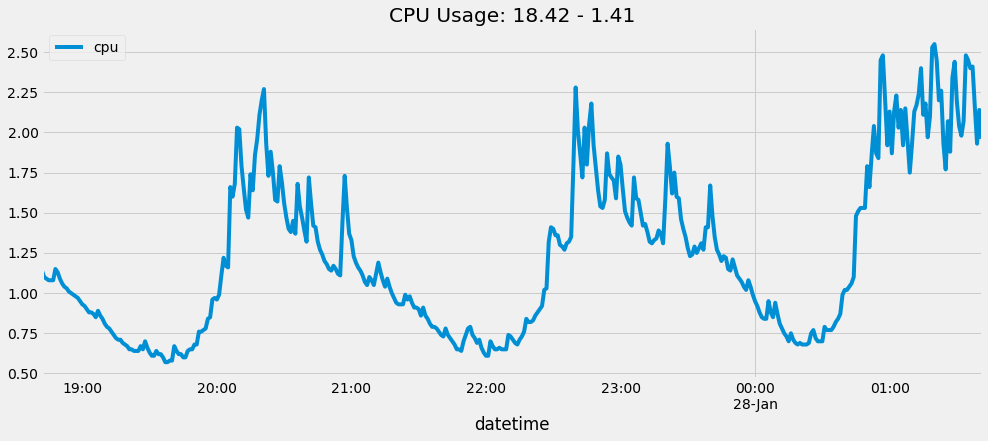

In [13]:
data_train_a.plot(title="CPU Usage: 18.42 - 1.41", figsize=(15,6))
plt.show()

There seems to be a seasonal component very two hours. Below we will perform a decomposition analysis.

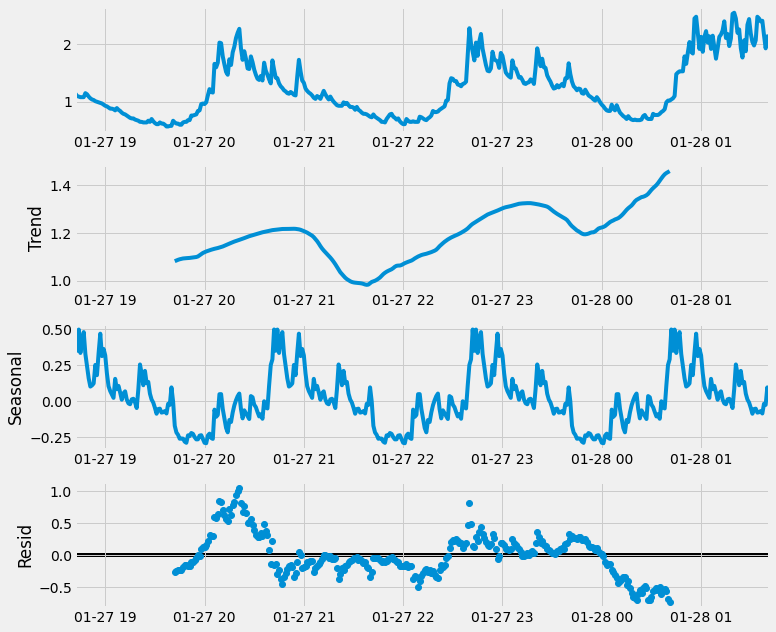

In [14]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(data_train_a,model='additive',period=60*2) # 2 hours period, the datetime is in minutes
fig = decomposition.plot()
plt.show()

Predicción usando Prophet
https://research.facebook.com/blog/2017/02/prophet-forecasting-at-scale/

In [15]:
data_train_a.reset_index(inplace=True)

In [16]:
data_train_a.rename(columns={'datetime': 'ds', 'cpu': 'y'}, inplace=True) # renombramos columnas porque Prophet lo requiere así

23:26:36 - cmdstanpy - INFO - Chain [1] start processing
23:26:36 - cmdstanpy - INFO - Chain [1] done processing


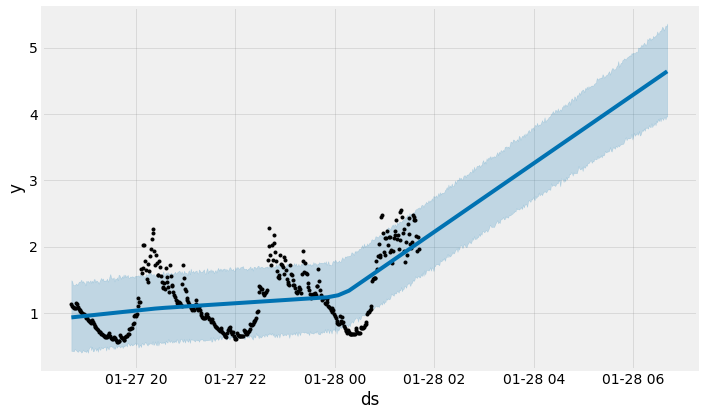

In [17]:
# Primer modelo sin cambiar parametros que vienen por default

m = Prophet()

m.fit(data_train_a)

future = m.make_future_dataframe(periods=300, freq='1min')
fcst = m.predict(future)
fig = m.plot(fcst)

23:26:45 - cmdstanpy - INFO - Chain [1] start processing
23:26:45 - cmdstanpy - INFO - Chain [1] done processing


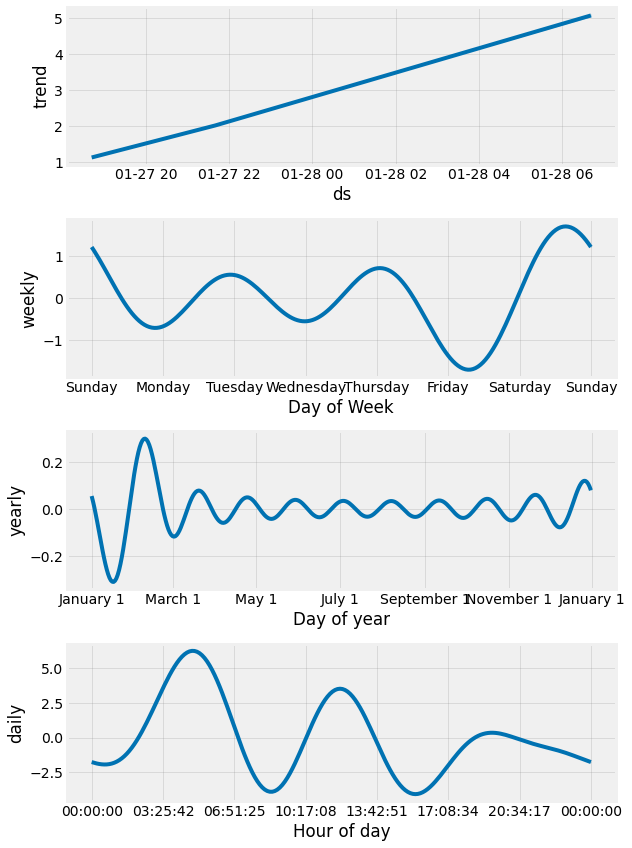

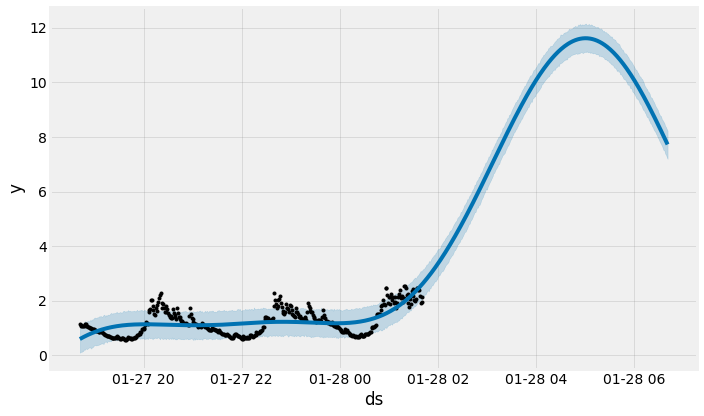

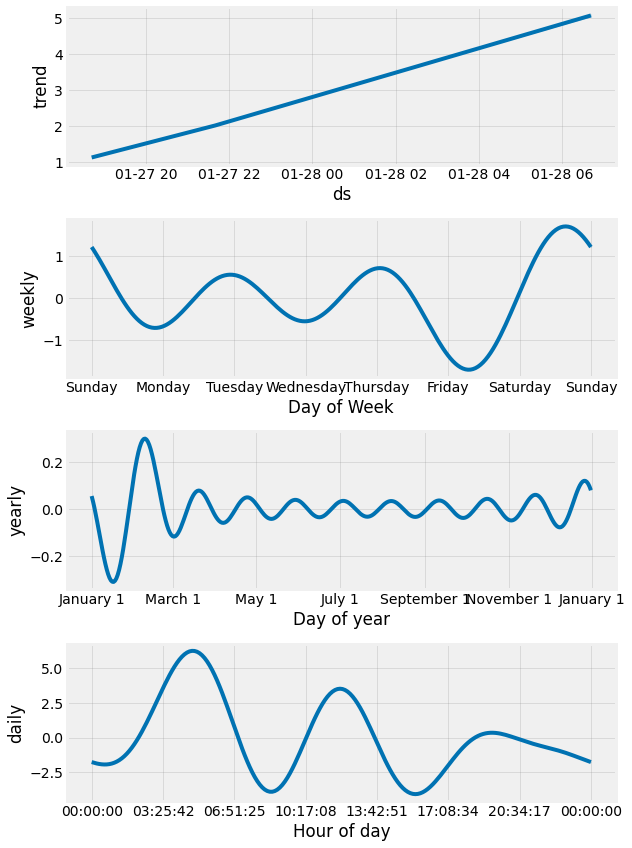

In [18]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True).fit(data_train_a)
future = m.make_future_dataframe(periods=300, freq='1min')
fcst = m.predict(future)
fig = m.plot(fcst)

m.plot_components(fcst)

2. Librería de arima

Given the seasonality of the data we will use a Seasonal ARIMA model (SARIMA)

We have to choose the parameters p, d, q for the ARIMA and P, D, Q for the seasonal component

In [19]:
data_train_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)

In [20]:
data_train_a.index = pd.to_datetime(data_train_a.index)

In [21]:
stepwise_model = auto_arima(data_train_a, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-273.302, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-368.085, Time=0.99 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-271.465, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-417.827, Time=2.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.44 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=8.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-419.762, Time=2.71 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-369.850, Time=0.97 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=11.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=13.97 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-417.860, Time=5.54 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-421.259, Time=9.19 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-37

In [22]:
stepwise_model.fit(data_train_a)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

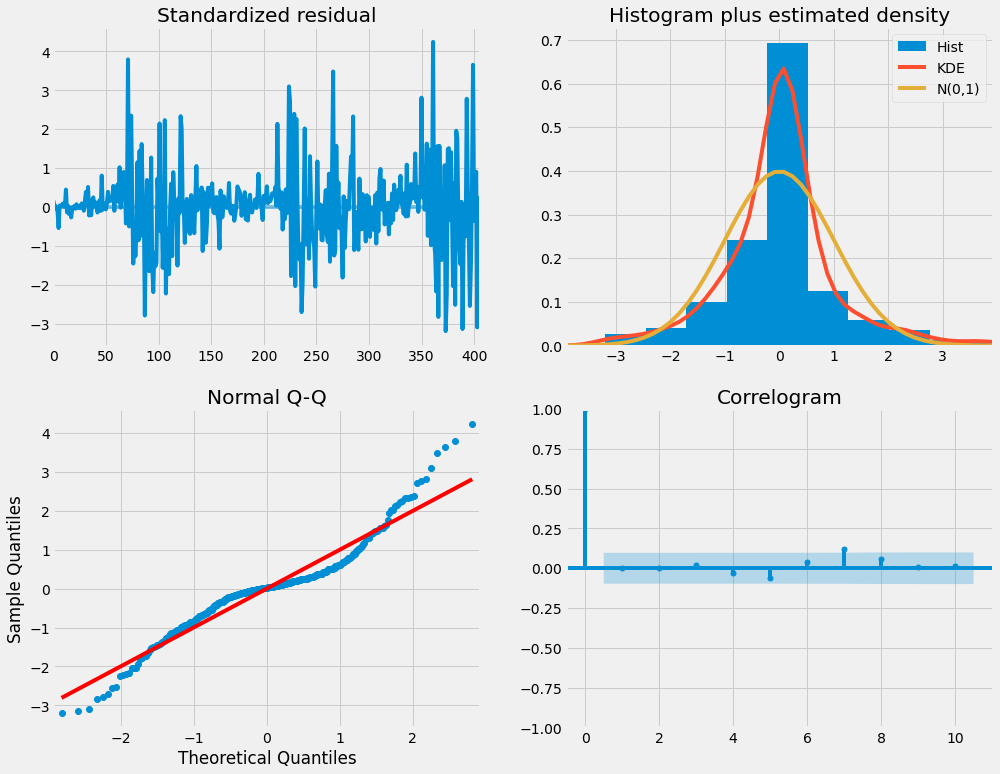

In [23]:
stepwise_model.fit(data_train_a).plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
future_forecast = stepwise_model.predict(n_periods=60)

<AxesSubplot:title={'center':'Actual followed by predicted values'}, xlabel='datetime'>

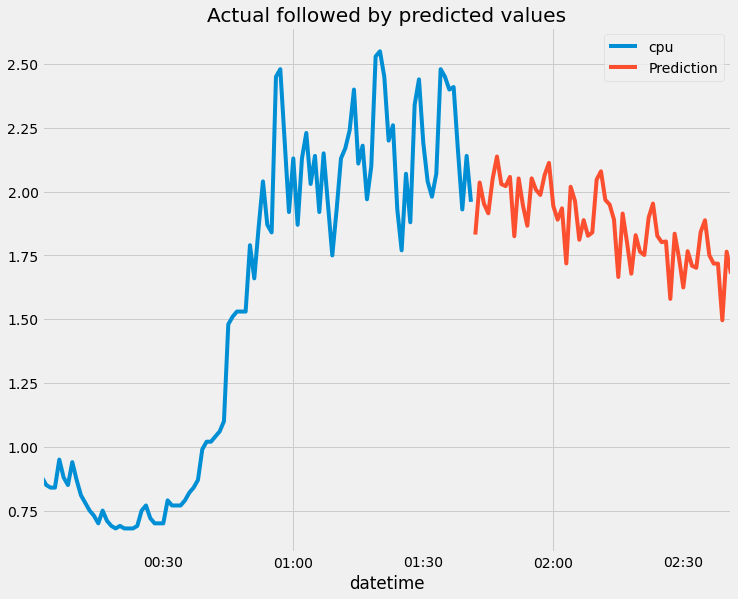

In [25]:
forecast_a = pd.DataFrame(future_forecast,index = data_test_a.index,columns=['Prediction'])
pd.concat([data_train_a.tail(100),forecast_a],axis=0).plot(title='Actual followed by predicted values')

<AxesSubplot:xlabel='datetime'>

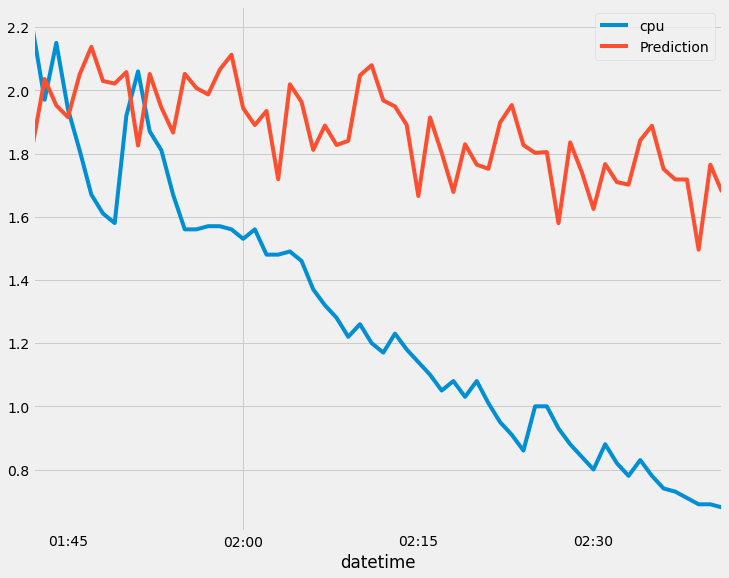

In [26]:
future_forecast = pd.DataFrame(future_forecast,index = data_test_a.index,columns=['Prediction'])
pd.concat([data_test_a,future_forecast],axis=1).plot()

Even though the prediction shows a decrease in the CPU usage since 1.40 am, the decrease in the actual data is higher.

Dataset b

Predicción usando Prophet

In [27]:
data_train_b.reset_index(inplace=True)

In [28]:
data_train_b.rename(columns={'datetime': 'ds', 'cpu': 'y'}, inplace=True) # renombramos columnas porque Prophet lo requiere así

23:34:49 - cmdstanpy - INFO - Chain [1] start processing
23:34:49 - cmdstanpy - INFO - Chain [1] done processing


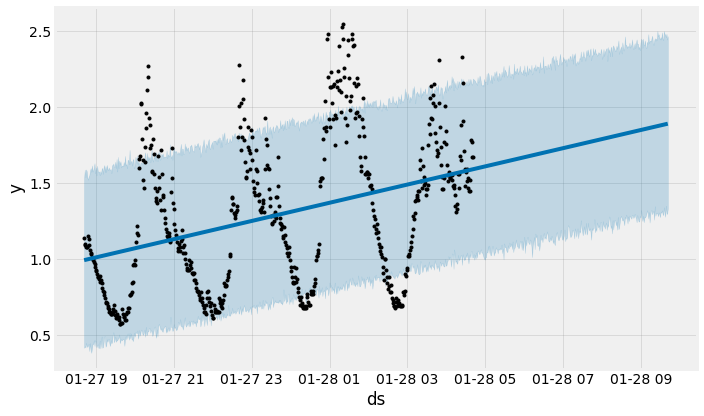

In [29]:
m = Prophet(changepoint_prior_scale=0.01).fit(data_train_b)
future = m.make_future_dataframe(periods=300, freq='1min')
fcst = m.predict(future)
fig = m.plot(fcst)

Predicción usando ARIMA

In [30]:
data_train_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)
data_test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv', parse_dates=[0], infer_datetime_format=True,index_col=0)


In [31]:

data_train_b.index = pd.to_datetime(data_train_b.index)

In [32]:
stepwise_model = auto_arima(data_train_b, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-376.973, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-540.238, Time=2.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=10.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-375.034, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-618.341, Time=4.72 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=19.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=11.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-619.706, Time=2.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-541.973, Time=0.87 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=26.45 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=6.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-618.493, Time=4.27 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=32.27 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-617.

In [33]:
stepwise_model.fit(data_train_b)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

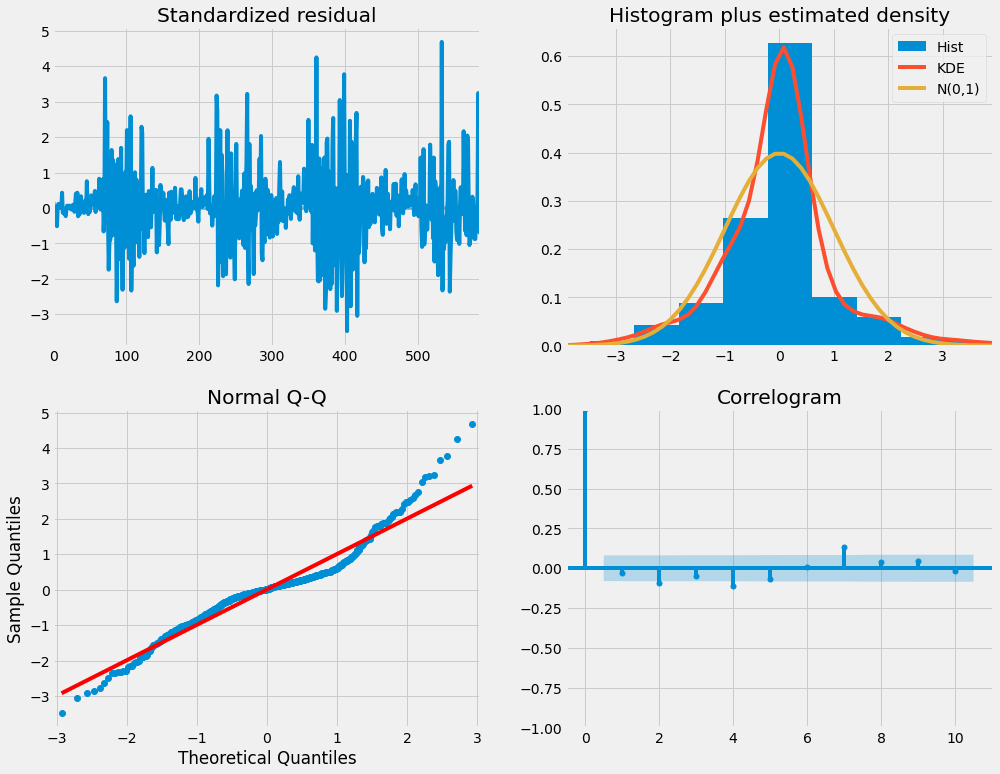

In [34]:
stepwise_model.fit(data_train_b).plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
future_forecast = stepwise_model.predict(n_periods=60)

<AxesSubplot:title={'center':'Actual followed by predicted values'}, xlabel='datetime'>

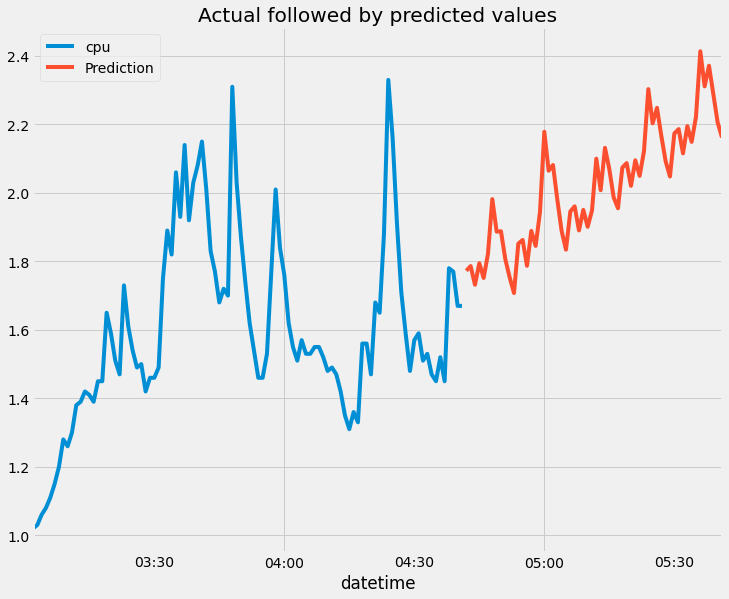

In [36]:
forecast_b = pd.DataFrame(future_forecast,index = data_test_b.index,columns=['Prediction'])
pd.concat([data_train_b.tail(100),forecast_b],axis=0).plot(title='Actual followed by predicted values')

<AxesSubplot:xlabel='datetime'>

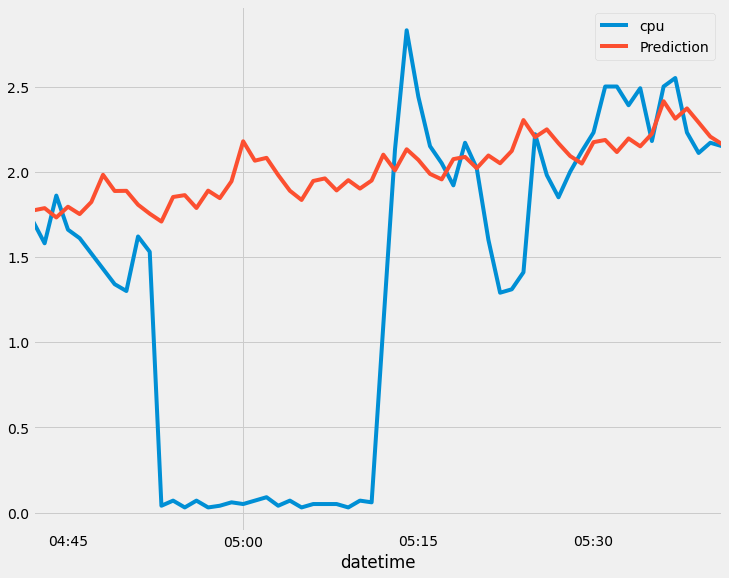

In [37]:
future_forecast = pd.DataFrame(future_forecast,index = data_test_b.index,columns=['Prediction'])
pd.concat([data_test_b,future_forecast],axis=1).plot()

The actual value of the CPU usage has a strong decrease around 5 am that cannot be predicted by the model, since it seems to be an outlier

After 5.15 am the model starts to predict a little bit better

Despite of this, the model needs to be improved given that the residuals do not meet the assumptions of an ARIMA model

Otra librería útil para series de tiempo: https://github.com/awslabs/gluon-ts